# Figure S4

In [17]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md
import random
from scipy import stats
from scipy.special import logit

## Bio functions
from Bio import AlignIO
from Bio import SeqIO

## Local functions
import sys
sys.path.append("../code/scripts")
import alignment_quality as aq
import chargepatterns as cp
import composition as comp
import crutil
import fractional_charge as fc


## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [3]:
all_aa2 = ['E', 'D', 'K', 'R', 'H', 'Q', 'P', 'N', 'A', 'T',
           'S', 'V', 'G', 'M', 'C', 'I', 'L', 'Y', 'F', 'W']

## 4A

In [4]:
scerprot = []
for record in SeqIO.parse("../data/ref_proteomes/Saccharomyces_cerevisiae.fasta", "fasta"):
    scerprot.append(record)
    
scercomp = np.zeros(20)
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    scercomp = np.add(scercomp, comp.get_composition(seq, all_aa2))
scercomp = np.divide(scercomp, len(scerprot))

In [5]:
hsprot = []
for record in SeqIO.parse("../data/ref_proteomes/Homo_sapiens.faa", "fasta"):
    hsprot.append(record)
    
hscomp = np.zeros(20)
for orf in hsprot:
    seq = str(orf.seq).replace('*', '').replace('U', '').replace('X', '')
    if seq.find('U') != -1:
        print(seq)
    hscomp = np.add(hscomp, comp.get_composition(seq, all_aa2))
hscomp = np.divide(hscomp, len(hsprot))

In [6]:
ceprot = []
for record in SeqIO.parse("../data/ref_proteomes/Caenorhabditis_elegans.faa", "fasta"):
    ceprot.append(record)

cecomp = np.zeros(20)
for orf in ceprot:
    seq = str(orf.seq).replace('*', '').replace('U', '').replace('X', '')
    cecomp = np.add(cecomp, comp.get_composition(seq, all_aa2))
cecomp = np.divide(cecomp, len(ceprot))

In [7]:
drosprot = []
for record in SeqIO.parse("../data/ref_proteomes/Drosophila_melanogaster.faa", "fasta"):
    drosprot.append(record)
    
droscomp = np.zeros(20)
for orf in drosprot:
    seq = str(orf.seq).replace('*', '').replace('U', '').replace('X', '')
    droscomp = np.add(droscomp, comp.get_composition(seq, all_aa2))
droscomp = np.divide(droscomp, len(drosprot))

In [8]:
musprot = []
for record in SeqIO.parse("../data/ref_proteomes/Mus_musculus.faa", "fasta"):
    musprot.append(record)

muscomp = np.zeros(20)
for orf in musprot:
    seq = str(orf.seq).replace('*', '').replace('U', '').replace('X', '')
    muscomp = np.add(muscomp, comp.get_composition(seq, all_aa2))
muscomp = np.divide(muscomp, len(musprot))

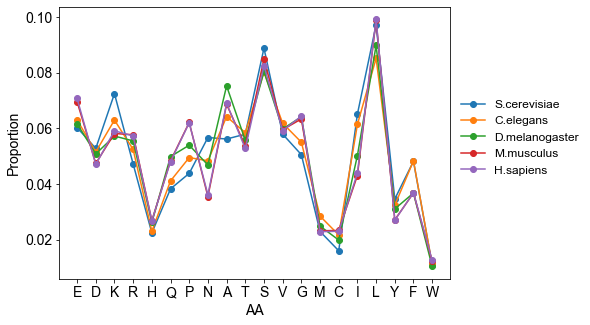

In [9]:
plt.figure(figsize=(7,5))
plt.plot(all_aa2, scercomp, marker='o')
plt.plot(all_aa2, cecomp, marker='o')
plt.plot(all_aa2, droscomp, marker='o')
plt.plot(all_aa2, muscomp, marker='o')
plt.plot(all_aa2, hscomp, marker='o')
plt.xlabel('AA', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(['S.cerevisiae', 'C.elegans', 'D.melanogaster', 'M.musculus', 'H.sapiens'],
           fontsize=12, bbox_to_anchor=(1, 0.7), frameon=False)
#plt.legend(['S.cerevisiae', 'Null'], fontsize=12, bbox_to_anchor=(1, 0.6), frameon=False)
#plt.savefig('./output/fig.png', dpi=300, bbox_inches='tight')
plt.show()

## 4B

In [10]:
def comp_to_dict(c):
    d = {}
    for i,aa in enumerate(comp.aas):
        d[aa] = c[i]
    return d

In [11]:
aybrah = ['Rhodotorula graminis',
        'Saitoella complicata',
        'Schizosaccharomyces pombe',
        'Aspergillus niger',
        'Neurospora crassa',
        'Trichoderma reesei',
        'Lipomyces starkeyi',
        'Yarrowia lipolytica',
        'Blastobotrys adeninivorans',
        'Nadsonia fulvescens',
        'Ascoidea rubescens',
        'Pachysolen tannophilus',
        'Komagataella phaffii',
        'Kuraishia capsulata',
        'Ogataea arabinofermentans',
        'Ogataea parapolymorpha',
        'Dekkera bruxellensis',
        'Pichia membranifaciens',
        'Pichia kudriavzevii',
        'Babjeviella inositovora',
        'Metschnikowia bicuspidata',
        'Meyerozyma guilliermondii',
        'Debaryomyces hansenii',
        'Scheffersomyces stipitis',
        'Spathaspora passalidarum',
        'Wickerhamomyces anomalus',
        'Cyberlindnera jadinii',
        'Hanseniaspora valbyensis',
        'Kluyveromyces lactis',
        'Lachancea thermotolerans',
        'Zygosaccharomyces rouxii',
        'Saccharomyces cerevisiae',
        'Vanderwaltozyma polyspora']

In [12]:
comp_dict = {}
for species in aybrah:
    name = species.split(' ')
    filepath = '../data/ref_proteomes/' + name[0] + '_' + name[1] + '.fasta'
    prot = []
    for record in SeqIO.parse(filepath, "fasta"):
        prot.append(record)
    
    c = np.zeros(20)
    for orf in prot:
        seq = str(orf.seq).replace('*', '').replace('X', '')
        c = np.add(c, comp.get_composition(seq, comp.aas))
    c = np.divide(c, len(prot))
    d = comp_to_dict(c)
    comp_dict[species] = d

In [18]:
df3 = pd.DataFrame(columns = ['species', 'AA', 'proportion', 'log.odds'])
for species in aybrah:
    c = comp_dict[species]
    for AA in comp.aas:
        rv = {}
        if species == 'Saccharomyces cerevisiae':
            rv = {'species': species}
        else:
            rv = {'species': 'others'}
        rv['AA'] = AA
        rv['proportion'] = c[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df3 = df3.append(rv, ignore_index=True)

In [19]:
df3_sc = df3[df3.species == 'Saccharomyces cerevisiae']
df3_nonsc = df3[df3.species != 'Saccharomyces cerevisiae']

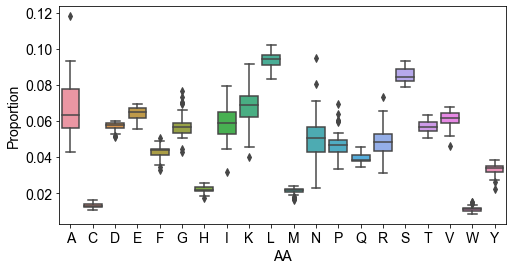

In [23]:
plt.figure(figsize=(8,4))
sns.boxplot(x="AA", y="proportion", data=df3)
#sns.swarmplot(x="AA", y="proportion", data=df3_nonsc,
#              color = '.3', linewidth=1, alpha=0.8, size=5)
#sns.swarmplot(x="AA", y="proportion", data=df3_sc,
#              color = 'cyan', linewidth=1, size=8, marker = 'D')
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('AA', fontsize=14)
plt.show()